In [1]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from typing import List

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import scipy.sparse as sp
from textblob import TextBlob
import warnings
import time
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [4]:
from wordcloud import WordCloud
from collections import Counter

In [5]:
import time
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, make_scorer, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

### Датасет

568 454 пользовательских отзывов о продуктах питания, опубликованных на Amazon с 1999 по 2012 г.


Первоначальные столбцы:

1. Id – порядковый номер записи

2. ProductId – уникальный идентификатор товара

3. UserId, ProfileName – данные автора

4. HelpfulnessNumerator, HelpfulnessDenominator – «сколько людей посчитали отзыв полезным / всего проголосовавших»

5. Score – оценка 1 - 5 звёзд

6. Time – UNIX-время публикации

7. Summary – краткий заголовок

8. Text – полный текст отзыва

Самая большая сложность данной работы - определение нейтральных отзывов. Они являются самым маленьким классом (около 7 процентов от всех отзывов), содержат слова как с позитивной окраской так и с отрицательной. Поэтому основной задачей этой работы было улучшение стандартных функций для распознования нейтральных отзывов.

### Задание 1

Подготовка и очистка текстов:

a.	Удалить пунктуацию, спецсимволы, лишние пробелы

b.	Привести текст к нижнему регистру

c.	Провести токенизацию, лемматизацию (с помощью nltk, spacy)

d.	Удалить стоп-слова


Загружаем стоп-слова, лемматизацию и токенизатор из nltk

In [7]:
nltk.download('stopwords') #загрузка стоп-слов
nltk.download('wordnet') #загрузка лемматизации
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Расширяем список стоп-слов невошедшими в загруженный словарь, но портящими анализ данных своей частотой.
Инициализируем стоп-слова и леммантизатор.

In [8]:
# Расширяем список стоп-слов
additional_stop_words = {'though', 'although'}
stop_words = set(stopwords.words('english')).union(additional_stop_words)
lemmatizer = WordNetLemmatizer()

Предобработка текста.

Вначале текст приводится к нижнему регистру, затем регулярными выражениями удаляются HTML-теги, ссылки и вся пунктуация. Восклицательные и вопросительные знаки заменяются маркерами, чтобы не потерять их эмоциональную нагрузку. Далее выполняется токенизация, после чего из получившегося набора слов исключаются английские стоп-слова и слишком короткие токены, а оставшиеся лемматизируются WordNet-лемматизатором.

In [9]:
def preprocess_text(text: str) -> List[str]:
    #Приведение к нижнему регистру
    text = text.lower()

    # Удаление HTML и ссылок
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'&[a-z]+;', ' ', text)
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)

    # Удаление остальной пунктуации
    text = re.sub(f'[{string.punctuation}]', ' ', text)
    text = re.sub(r'[^\w\s!?]', ' ', text)
    text = ' '.join(text.split())

    text = text.replace('!', 'exclamation_mark')
    text = text.replace('?', 'question_mark')

    # Токенизация
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Лемматизация с сохранением важных слов
    tokens = [lemmatizer.lemmatize(token) for token in tokens
              if token not in stop_words and len(token) > 2]

    return tokens

In [10]:
df = pd.read_csv('/content/Reviews.csv')

print("\n10 Оригинальных отзывов:")
print("=" * 80)
for i, review in enumerate(df['Text'].head(10)):
    print(f"\nОригинальный отзыв {i+1}:")
    print(review[:200] + "..." if len(review) > 200 else review)

df['Tokens'] = df['Text'].apply(preprocess_text)
df['Processed_Text'] = df['Tokens'].apply(lambda x: ' '.join(x))

print("\n10 Обработанных отзывов:")
print("=" * 80)
for i, tokens in enumerate(df['Tokens'].head(10)):
    print(f"\nОбработанный отзыв {i+1}:")
    print(' '.join(tokens[:20]) + "..." if len(tokens) > 20 else ' '.join(tokens))



10 Оригинальных отзывов:

Оригинальный отзыв 1:
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador...

Оригинальный отзыв 2:
Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".

Оригинальный отзыв 3:
This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powd...

Оригинальный отзыв 4:
If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The flavor...

Оригинальный отзыв 5:
Great taffy at a great price.  There was a wide assortme

Текст успешно предобработан, стал чище, подхлдит для дальнейшей работы

### Задание 2

Разведочный анализ текстов (EDA):

a.	Вычислить длину отзывов (в словах/символах), построить распределения

b.	Построить облака слов (wordcloud) и графики частотности

c.	Исследовать взаимосвязь между оценкой (Rating) и длиной


В количествах слов в отзывах есть разброс, большинство отзывов составляют 20-30 слов, но есть определенные выбросы до 2000 слов, с их учетом добавляем фильтрацию для удобства анализа количества слов в отзывах. Используем квантиль  0.85, чтобы не терять типичные отзывы.

In [11]:
def apply_outlier_removal_to_dataset(df):
    # Проверяем тип данных и обрабатываем соответствующим образом
    if isinstance(df, tuple):
        # Если df - кортеж, берем первый элемент (предполагаем, что это DataFrame)
        df_actual = df[0]
    else:
        df_actual = df

    # Создаем копию DataFrame для безопасной работы
    df_copy = df_actual.copy()

    # Считаем количество слов в каждом отзыве
    # Используем .str.len() для работы с Series, содержащими списки
    df_copy['word_count'] = df_copy['Tokens'].str.len()

    # Находим 85-й квантиль
    upper_quantile = df_copy['word_count'].quantile(0.85)

    # Фильтруем выбросы
    df_clean = df_copy[df_copy['word_count'] <= upper_quantile].copy()

    # Статистика по выбросам
    num_outliers = (df_copy['word_count'] > upper_quantile).sum()
    outlier_stats = {
        'upper_quantile': upper_quantile,
        'num_outliers': num_outliers,
        'original_size': len(df_copy),
        'cleaned_size': len(df_clean)
    }

    return df_clean, outlier_stats

In [12]:
# Применяем функцию удаления выбросов
df_clean, outlier_stats = apply_outlier_removal_to_dataset(df)

# Выводим статистику
print("Статистика удаления выбросов:")
print(f"Верхний квантиль (85%): {outlier_stats['upper_quantile']:.0f} слов")
print(f"Количество выбросов: {outlier_stats['num_outliers']:,}")
print(f"Исходный размер: {outlier_stats['original_size']:,}")
print(f"Размер после очистки: {outlier_stats['cleaned_size']:,}")
print(f"Удалено: {outlier_stats['num_outliers']:,} отзывов ({(outlier_stats['num_outliers']/outlier_stats['original_size']*100):.1f}%)")

# Обновляем рабочий датафрейм
df = df_clean.copy()

Статистика удаления выбросов:
Верхний квантиль (85%): 64 слов
Количество выбросов: 83,775
Исходный размер: 568,454
Размер после очистки: 484,679
Удалено: 83,775 отзывов (14.7%)


Функция сначала считает для каждого текста число токенов и суммарную длину этих токенов в символах, после чего визуализирует оба показателя гистограммами, дополняя их линиями среднего и медианы для наглядной оценки центра распределений.

In [13]:
def analyze_text_lengths(df):
    # Вычисляем длину в словах и символах
    df['word_count'] = df['Tokens'].str.len()
    df['char_count'] = df['Tokens'].apply(lambda x: sum(len(token) for token in x))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Распределение длины в словах
    sns.histplot(data=df, x='word_count', bins=30, ax=ax1,
                color='skyblue', edgecolor='black')
    ax1.set_title('Распределение длины отзывов (в словах)\nбез выбросов')
    ax1.set_xlabel('Количество слов')
    ax1.set_ylabel('Частота')

    # Добавляем вертикальные линии для среднего и медианы
    mean_words = df['word_count'].mean()
    median_words = df['word_count'].median()
    ax1.axvline(mean_words, color='red', linestyle='--', alpha=0.5,
                label=f'Среднее: {mean_words:.1f}')
    ax1.axvline(median_words, color='green', linestyle='--', alpha=0.5,
                label=f'Медиана: {median_words:.1f}')
    ax1.legend()

    # Распределение длины в символах
    sns.histplot(data=df, x='char_count', bins=30, ax=ax2,
                color='lightgreen', edgecolor='black')
    ax2.set_title('Распределение длины отзывов (в символах)\nбез выбросов')
    ax2.set_xlabel('Количество символов')
    ax2.set_ylabel('Частота')

    # Добавляем вертикальные линии для среднего и медианы
    mean_chars = df['char_count'].mean()
    median_chars = df['char_count'].median()
    ax2.axvline(mean_chars, color='red', linestyle='--', alpha=0.5,
                label=f'Среднее: {mean_chars:.1f}')
    ax2.axvline(median_chars, color='green', linestyle='--', alpha=0.5,
                label=f'Медиана: {median_chars:.1f}')
    ax2.legend()

    # Добавляем информацию о выбросах
    outliers_words = len(df) - len(df)
    outliers_percent = (outliers_words / len(df)) * 100

    fig.suptitle(f'Распределение длины отзывов\n', y=1.05)

    plt.tight_layout()
    plt.show()


    return df

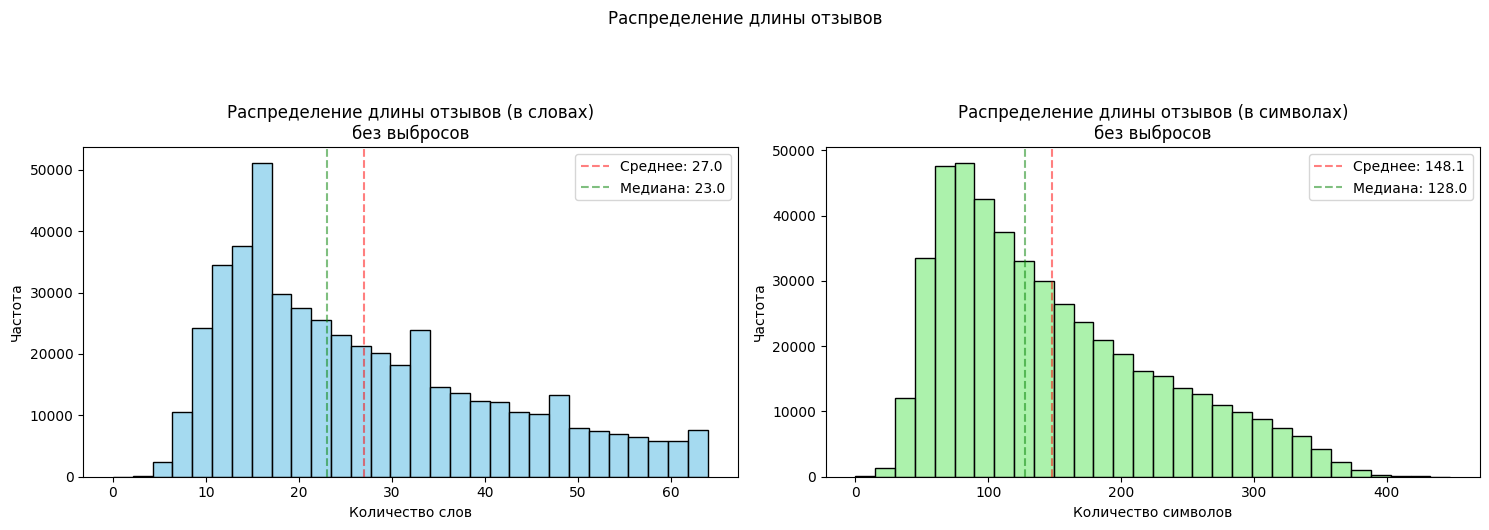

In [14]:
analyze_text_lengths(df);

Для создания облака слов использовали Counter() и подавали данные батчами, чтобы избежать ошибки памяти.

In [15]:
def create_wordcloud(df, max_words=1000, batch_size=1000):
    # Создание облака слов с обработкой всех текстов порциями для экономии памяти

    # Инициализируем счетчик для подсчета частоты слов
    word_freq = Counter()

    for i in range(0, len(df), batch_size):
        # Берем текущую порцию данных
        batch = df.iloc[i:i + batch_size]
        # Объединяем токены из текущей порции
        batch_text = ' '.join([' '.join(tokens) for tokens in batch['Tokens'].dropna()])
        # Обновляем счетчик частоты слов
        word_freq.update(batch_text.split())

    # Создаем облако слов на основе накопленной частоты слов
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=max_words,
        contour_width=3,
        contour_color='steelblue',
        collocations=False
    ).generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Облако слов из всех отзывов')
    plt.show()

    # Выводим статистику
    total_words = sum(word_freq.values())
    unique_words = len(word_freq)
    print(f"\nСтатистика облака слов:")
    print(f"Всего слов: {total_words:,}")
    print(f"Уникальных слов: {unique_words:,}")
    print(f"Отображено слов в облаке: {max_words:,}")

    print("\nТоп-10 самых частых слов:")
    for word, freq in word_freq.most_common(10):
        print(f"{word}: {freq:,} раз")

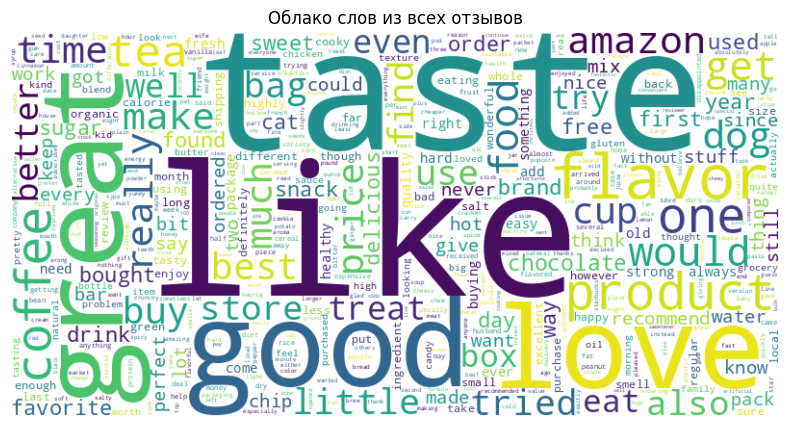


Статистика облака слов:
Всего слов: 13,069,588
Уникальных слов: 77,108
Отображено слов в облаке: 1,000

Топ-10 самых частых слов:
like: 171,075 раз
taste: 149,007 раз
good: 142,956 раз
great: 134,029 раз
love: 131,937 раз
flavor: 124,209 раз
product: 123,289 раз
one: 117,431 раз
coffee: 116,663 раз
tea: 96,968 раз


In [16]:
create_wordcloud(df, max_words=1000, batch_size=1000)

Частотное ядро формируют слова, связанные со вкусовыми впечатлениями и положительной оценкой. Лидирующие «like», «taste», «good», «great», «love» сигнализируют о преобладании позитивных эмоциональных реакций.

Так же с помощью Counter() подсчитываем частоту слов

In [17]:
def plot_word_frequencies(df):
    # Объединяем все токены
    all_words = [word for tokens in df['Tokens'].dropna() for word in tokens]

    # Считаем частоту слов
    word_freq = Counter(all_words)

    # Берем топ-20 слов
    top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]
    words, freqs = zip(*top_words)

    # Строим график
    plt.figure(figsize=(12, 6))
    plt.bar(words, freqs)
    plt.xticks(rotation=45, ha='right')
    plt.title('Топ-20 самых частых слов')
    plt.xlabel('Слова')
    plt.ylabel('Частота')
    plt.tight_layout()
    plt.show()

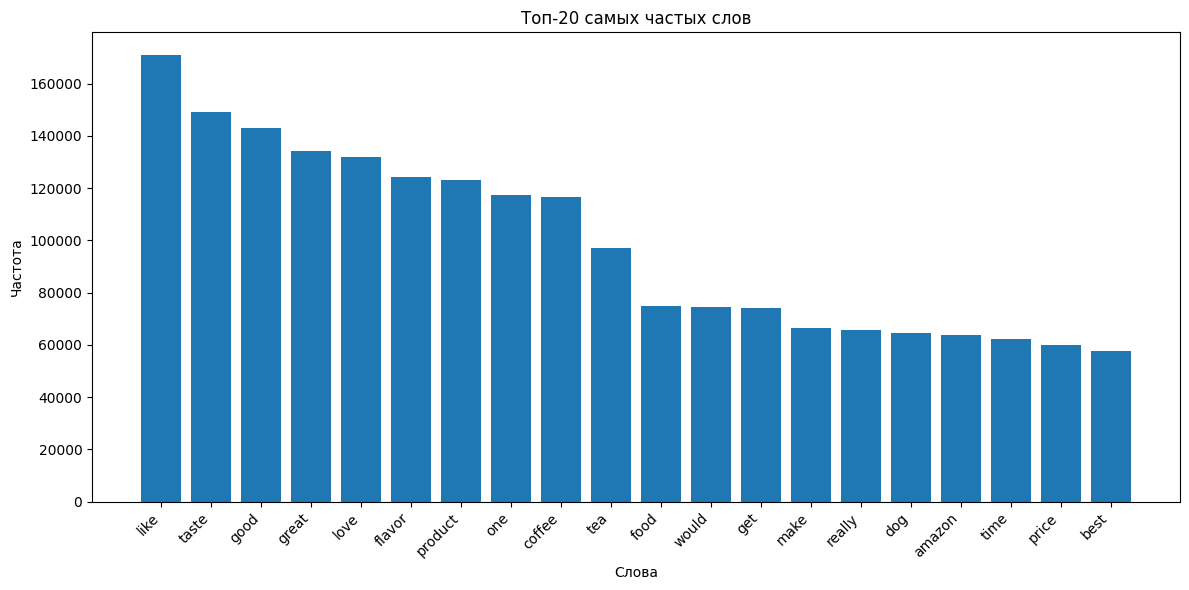

In [18]:
plot_word_frequencies(df)

In [19]:
def analyze_rating_length_correlation(df):
    # Точечный график
    sns.boxplot(data=df, x='Score', y='word_count')
    plt.title('Зависимость длины отзыва от оценки')
    plt.xlabel('Оценка')
    plt.ylabel('Количество слов')

    plt.tight_layout()
    plt.show()

    # Вычисляем корреляцию
    correlation = df['Score'].corr(df['word_count'])
    print(f"\nКорреляция между оценкой и длиной отзыва: {correlation:.3f}")

Выводы аналогичные тем, что были сделаны в облаке.

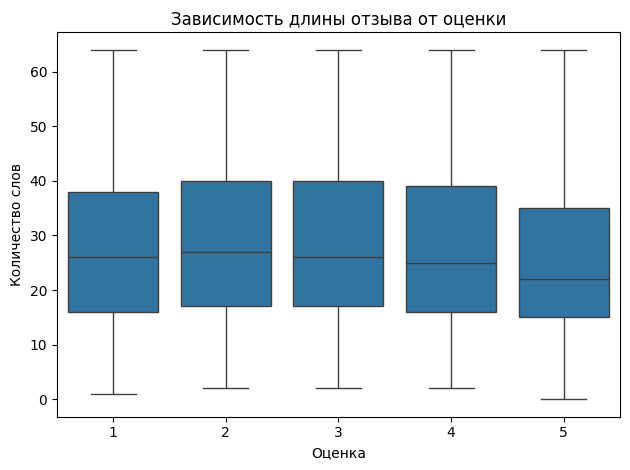


Корреляция между оценкой и длиной отзыва: -0.075


In [20]:
analyze_rating_length_correlation(df)

Значение −0,075 близко к нулю и указывает на почти полное отсутствие связи между количеством слов и поставленной оценкой: как короткие, так и длинные тексты встречаются при любых баллах. Хотя небольшая разница заметна: самые плохие отзывы и самые хорошие отзывы имеют чуть большую длину, чем менее критичные и нейтральные отзывы. Это можно объяснить психологией людей, что они более склонны к детальному описанию своего опыта при ярких эмоциях - позитивных или негативных.

In [21]:
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('maxent_ne_chunker', quiet=True)
nltk.download('words', quiet=True)

True

### Задание 3

Преобразовать текст в числовое представление

a. TF-IDF — TfidfVectorizer из sklearn

b. Word2Vec, BERT embeddings — по желанию

c. длина текста, число положительных слов и т.п



Функция разбивает отзыв на предложения, оценивает полярность каждого с помощью TextBlob, затем измеряет, насколько тональность колеблется от одной фразы к другой, усредняя, фиксируя максимум и дисперсию этих колебаний. Тем самым она количественно описывает «эмоциональные качели» внутри текста: Это может помочь с поиском нейтральных отзывов, которые зачастую строятся на похвале товара с описанием непонравившихся моментов.

In [32]:
def calculate_sentiment_shift(text):
      try:
            sentences = text.split('.')
            sentences = [s.strip() for s in sentences if len(s.strip()) > 0]

            if len(sentences) < 2:
                return 0, 0, 0

            # Вычисляем тональность для каждого предложения
            sentence_sentiments = []
            for sentence in sentences:
                if len(sentence.strip()) > 0:
                    sentiment = TextBlob(sentence).sentiment.polarity
                    sentence_sentiments.append(sentiment)

            if len(sentence_sentiments) < 2:
                return 0, 0, 0

            # Статистики смены тональности
            sentiment_changes = []
            for i in range(1, len(sentence_sentiments)):
                change = abs(sentence_sentiments[i] - sentence_sentiments[i-1])
                sentiment_changes.append(change)

            # Среднее изменение тональности
            avg_sentiment_change = np.mean(sentiment_changes)

            # Максимальное изменение тональности
            max_sentiment_change = np.max(sentiment_changes)

            # Стандартное отклонение тональности
            sentiment_std = np.std(sentence_sentiments)

            return avg_sentiment_change, max_sentiment_change, sentiment_std

      except:
            return 0, 0, 0

Функция создания вектора признаков.

За основу признаков взят tf-idf.

Далее статистические признаки

1. word_count, char_count — длина текста в некоторой степени коррелирует c Score, поэтомуу было решено оставить количества в признаках.
2. avg_word_length — сложные слова чаще в позитиве чаще встречаются при сильных эмоциях.
3. lexical_diversity = частота уникальных/общих слов. В нейтрале лексика сдержаннее из-за отсутствия эмоций.
4. text_entropy — более формальное мера разнообразия; дополняет предыдущий признак.

Пунктуация
1. exclamation_count и question_count — При предобработке были оставлены восклицательные и вопросительные знаки для определения тональности. Недовольные покупатели чаще задают вопросы, а счастливые используют восклицания.
2. punct_ratio, emotion_intensity — нормируем на длину, чтобы длинные тексты не доминировали

Семантика через TextBlob
Выбрана, потому что быстро считается и даёт две скалярные оценки:
1. polarity(-1...1) - положительность или отрицательность с помощью библиотеки Textblob
2. subjectivity (0...1) - объективность или субъективность т.е наполненность чувствами текста
2. polarity_abs - абсолютное значение полярности, которое игнорирует направление (положительное или отрицательное), но указывает на интенсивность чувства
3. subjectivity_squared -  квадрат субъективности, который увеличивает разрыв между значениями - более субъективные тексты будут еще более выделены.в.
4. neutrality_score = 1 - |polarity|, moderation_score = 1 – subjectivity - насколько близко к нейтрали.

Текстовые метрики сложности/повторяемости

1. complex_words (>6 симв.) и complex_ratio - сложная лексика чаще в позитиве.

2. repetition_scores - доля самого частого слова; резкое повторение («bad bad bad») типично для негатива.

Социальный сигнал Helpful Votes

1. helpfulness_numerator - denominator показывает, что отзывы, сочтённые полезными, чаще нейтральны/длинны.

Смена тональности внутри отзыва

Описана в функции ранее


In [33]:
def create_features_improved(df):

    print("Создание признаков")

    print("1. СозданиеTF-IDF признаков")

    # Основной TF-IDF с расширенными параметрами
    tfidf_main = TfidfVectorizer(
        max_features=15000,
        min_df=2,
        max_df=0.85,
        ngram_range=(1, 2),
        sublinear_tf=True,
        analyzer='word',
        norm='l2'
    )

    processed_texts = df['Tokens'].apply(lambda x: ' '.join(x))
    tfidf_main_matrix = tfidf_main.fit_transform(processed_texts)

    print("2. Создание статистических признаков")

    # Базовые статистики
    word_count = processed_texts.str.split().str.len().values
    char_count = processed_texts.str.len().values

    # Средняя длина слов
    avg_word_length = processed_texts.str.split().apply(
        lambda x: np.mean([len(word) for word in x]) if x else 0
    ).values

    # Лексическое разнообразие
    lexical_diversity = processed_texts.str.split().apply(
        lambda x: len(set(x)) / len(x) if len(x) > 0 else 0
    ).values

    # Энтропия текста
    def text_entropy(text):
        if not text:
            return 0
        words = text.split()
        if len(words) == 0:
            return 0
        word_freq = Counter(words)
        total_words = len(words)
        entropy = 0
        for freq in word_freq.values():
            p = freq / total_words
            if p > 0:
                entropy -= p * np.log2(p)
        return entropy

    text_entropy_values = processed_texts.apply(text_entropy).values

    print("3. Создание пунктуационных признаков")

    # Подсчет знаков препинания
    exclamation_count = df['Text'].str.count('exclamation_mark').values
    question_count = df['Text'].str.count(r'question_mark').values

    # Соотношения
    punct_ratio = (exclamation_count + question_count) / (word_count + 1)

    # Интенсивность эмоций (восклицания)
    emotion_intensity = (exclamation_count) / (word_count + 1)

    print("4. Создание семантических признаков")

    # TextBlob с расширенными параметрами
    polarity = df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity).values
    subjectivity = df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity).values

    # Дополнительные семантические признаки
    polarity_abs = np.abs(polarity)
    subjectivity_squared = subjectivity ** 2

    # Признаки нейтральности
    neutrality_score = 1 - polarity_abs
    moderation_score = 1 - subjectivity

    print("5. Создание текстовых признаков")

    # Признаки сложности
    complex_words = processed_texts.str.split().apply(
        lambda x: sum(1 for word in x if len(word) > 6) if x else 0
    ).values
    complex_ratio = complex_words / (word_count + 1)

    # Признаки повторений
    def repetition_score(text):
        if not text:
            return 0
        words = text.split()
        if len(words) == 0:
            return 0
        word_freq = Counter(words)
        max_freq = max(word_freq.values())
        return max_freq / len(words)

    repetition_scores = processed_texts.apply(repetition_score).values

    print("6. Создание признаков Helpful Votes")

    helpfulness_numerator = df['HelpfulnessNumerator'].fillna(0).values
    helpfulness_denominator = df['HelpfulnessDenominator'].fillna(0).values

    helpful_votes = helpfulness_numerator - helpfulness_denominator

    print("7. Создание признаков смены тональности")

    sentiment_shift_results = df['Text'].apply(calculate_sentiment_shift)
    avg_sentiment_change = np.array([r[0] for r in sentiment_shift_results])
    max_sentiment_change = np.array([r[1] for r in sentiment_shift_results])
    sentiment_std = np.array([r[2] for r in sentiment_shift_results])

    print("8. Объединение всех признаков")

    additional_features = np.column_stack([
        # Базовые статистики
        word_count, char_count, avg_word_length, lexical_diversity, text_entropy_values,

        # Пунктуационные признаки
        exclamation_count, question_count,
        punct_ratio, emotion_intensity,

        # Семантические признаки
        polarity, subjectivity, polarity_abs, subjectivity_squared,
        neutrality_score, moderation_score,

        # Текстовые признаки
        complex_words, complex_ratio, repetition_scores,

        #Helpful Votes
        helpful_votes,

        #Sentiment Shift
        avg_sentiment_change, max_sentiment_change, sentiment_std

    ])

    # Нормализация
    scaler = StandardScaler()
    additional_features_scaled = scaler.fit_transform(additional_features)

    # Объединение всех TF-IDF и дополнительных признаков
    from scipy.sparse import hstack, csr_matrix
    X = hstack([
        tfidf_main_matrix,
        csr_matrix(additional_features_scaled)
    ])


    print(f"TF-IDF: {tfidf_main_matrix.shape[1]} признаков")
    print(f"Дополнительные: {additional_features.shape[1]} признаков")

    return X, tfidf_main, scaler, additional_features

In [43]:
# Создаем признаки
X, tfidf_vectorizer, scaler, additional_features = create_features_improved(df)

Создание признаков
1. СозданиеTF-IDF признаков
2. Создание статистических признаков
3. Создание пунктуационных признаков
4. Создание семантических признаков
5. Создание текстовых признаков
6. Создание признаков Helpful Votes
7. Создание признаков смены тональности
8. Объединение всех признаков
TF-IDF: 15000 признаков
Дополнительные: 22 признаков


### Задание 4
Формирование целевой переменной:

a.	На основе Rating разметить отзывы по классам

  1-2 — негативный

  3 — нейтральный

  4-5 — позитивный

b.	Проверить сбалансированность классов

c.	При необходимости — применить class_weight='balanced' или SMOTE.


Функция решает две основные задачи:
1. Превращает исходный 5-звёздочный рейтинг Amazon (Score) в трёхклассовую целевую переменную, совместимую с задачей.
2. Сразу же анализирует баланс классов.

In [34]:
def create_target_variable(df):
    print("Создание целевой переменной")

    def categorize_sentiment(score):
        if score <= 2:
            return 0  # Негативный
        elif score == 3:
            return 1  # Нейтральный
        else:  # score >= 4
            return 2  # Позитивный

    df['sentiment'] = df['Score'].apply(categorize_sentiment)

    # Создаем текстовые метки
    sentiment_labels = {0: 'Негативный', 1: 'Нейтральный', 2: 'Позитивный'}
    df['sentiment_label'] = df['sentiment'].map(sentiment_labels)

    # Анализ распределения классов
    print("\nРаспределение классов:")
    class_counts = df['sentiment'].value_counts().sort_index()
    class_percentages = df['sentiment'].value_counts(normalize=True).sort_index() * 100

    for sentiment, label in sentiment_labels.items():
        count = class_counts[sentiment]
        percentage = class_percentages[sentiment]
        print(f"   {label}: {count:,} ({percentage:.1f}%)")

    # Визуализация
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    sentiment_counts = df['sentiment_label'].value_counts()
    colors = ['red', 'orange', 'green']
    ax1.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
    ax1.set_title('Распределение классов тональности')
    ax1.set_xlabel('Класс тональности')
    ax1.set_ylabel('Количество отзывов')

    for i, v in enumerate(sentiment_counts.values):
        ax1.text(i, v + max(sentiment_counts.values) * 0.01, f'{v:,}',
                ha='center', va='bottom')

    ax2.pie(sentiment_counts.values, labels=sentiment_counts.index,
            colors=colors, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Процентное распределение классов')

    plt.tight_layout()
    plt.show()

    # Проверка сбалансированности
    min_class = class_counts.min()
    max_class = class_counts.max()
    imbalance_ratio = max_class / min_class

    print(f"\nАнализ сбалансированности:")
    print(f"   Наименьший класс: {min_class:,} образцов")
    print(f"   Наибольший класс: {max_class:,} образцов")
    print(f"   Коэффициент дисбаланса: {imbalance_ratio:.2f}")

    needs_balancing = imbalance_ratio > 3

    return df, needs_balancing


Создание целевой переменной

Распределение классов:
   Негативный: 68,524 (14.1%)
   Нейтральный: 33,766 (7.0%)
   Позитивный: 382,389 (78.9%)


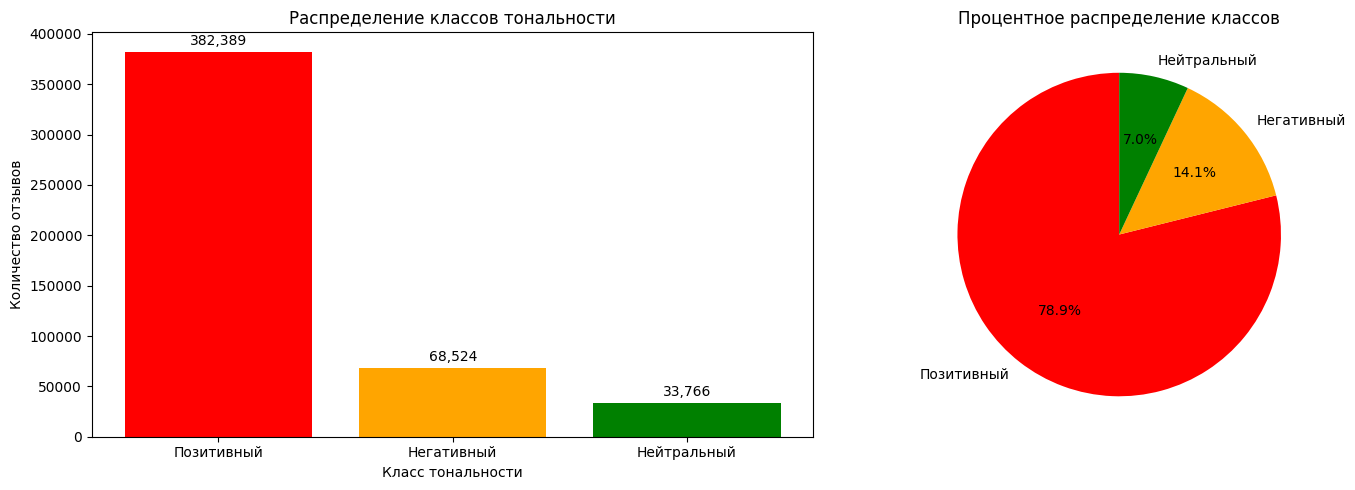


Анализ сбалансированности:
   Наименьший класс: 33,766 образцов
   Наибольший класс: 382,389 образцов
   Коэффициент дисбаланса: 11.32


In [44]:
df, needs_balancing = create_target_variable(df)
y = df['sentiment'].values

Как мы видим из графиков классы критически несбалансированы. При обучении модели используется class_weight='balanced'. Также в разных вариантах был использован SMOTE, но он не дал большого прироста в точности, хотя значительно увеличил время тренировки модели. Поэтому было решено использовать class_weight='balanced

### Задание 5
Обучение моделей:

a.	Разделить выборку на обучающую и тестовую (например, 80/20)

b.	Обучить минимум одну классическую модель (LogisticRegression, SVM) и (по желанию) одну нейросетевую (BERT через HuggingFace)

c.	Оценить с помощью метрик

1. Accuracy

2. F1-score (по каждому классу)


Была использована логистическая регрессия в самых разных вариантах и с самыми разными параметрами, также была протестирована
svm, но они ни обдна из них не дала результата точности определения больше 50% для нейтральных классов. Не найдено действенного метода определения нейтрального класса. В коде использована самая быстрая модель.

In [62]:
def train_single_model(X, y):

    start_time = time.time()

    # Разделение данных
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Размеры данных: Train={X_train.shape[0]:,}, Test={X_test.shape[0]:,}")

    # Анализ распределения классов
    unique_classes, class_counts = np.unique(y_train, return_counts=True)
    print(f"Распределение классов:")
    for class_id, count in zip(unique_classes, class_counts):
        class_name = ['Негативный', 'Нейтральный', 'Позитивный'][class_id]
        print(f"   {class_name}: {count:,} ({count/len(y_train)*100:.1f}%)")

    # Создаем модель LogisticRegression с class_weight='balanced'
    model = LogisticRegression(
        max_iter=5000,
        random_state=42,
        solver='lbfgs',
        class_weight='balanced',      # Автоматическая балансировка весов
        C=1.0,
        multi_class='multinomial',
        penalty='l2',
    )

    print("\n Обучение LogisticRegression с class_weight='balanced'")

    # Обучение модели
    model.fit(X_train, y_train)

    # Предсказания
    predictions = model.predict(X_test)

    # Вычисление метрик
    accuracy = accuracy_score(y_test, predictions)
    f1_macro = f1_score(y_test, predictions, average='macro')
    f1_weighted = f1_score(y_test, predictions, average='weighted')
    f1_per_class = f1_score(y_test, predictions, average=None)

    training_time = time.time() - start_time

    print(f"Обучение завершено за {training_time:.2f}s")
    print(f"\n Результаты:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-macro: {f1_macro:.4f}")
    print(f"F1-weighted: {f1_weighted:.4f}")
    print(f"F1 по классам:")
    print(f"Негативный: {f1_per_class[0]:.4f}")
    print(f"Нейтральный: {f1_per_class[1]:.4f}")
    print(f"Позитивный: {f1_per_class[2]:.4f}")

    # Создаем результат в совместимом формате
    results = {
        'LogisticRegression_Balanced': {
            'model': model,
            'predictions': predictions,
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'f1_per_class': f1_per_class,
            'training_time': training_time,
            'balancing_method': 'class_weight_balanced'
        }
    }

    return results, X_test, y_test


In [71]:
# Обучение модели
results, X_test, y_test = train_single_model(X, y)

Размеры данных: Train=387,743, Test=96,936
Распределение классов:
   Негативный: 54,819 (14.1%)
   Нейтральный: 27,013 (7.0%)
   Позитивный: 305,911 (78.9%)

 Обучение LogisticRegression с class_weight='balanced'
Обучение завершено за 312.89s

 Результаты:
Accuracy: 0.8257
F1-macro: 0.6837
F1-weighted: 0.8484
F1 по классам:
Негативный: 0.7387
Нейтральный: 0.4052
Позитивный: 0.9071


Хотя общая точность и высока, это обуславливается большим количеством попаданий в положительные отзывы. Тончост определения нейтральныых отзывов составляет 0.4

In [69]:
def evaluate_single_model(results, y_test):
    print("\nОценка модели")
    print("=" * 60)

    sentiment_labels = ['Негативный', 'Нейтральный', 'Позитивный']

    model_name, result = list(results.items())[0]
    predictions = result['predictions']

    if result['training_time'] > 0:
        print(f"Время обучения: {result['training_time']:.2f}s")

    print(f"\nОсновные метрики:")
    print(f"   Accuracy: {result['accuracy']:.4f}")
    print(f"   F1-macro: {result['f1_macro']:.4f}")
    print(f"   F1-weighted: {result['f1_weighted']:.4f}")

    # Создаем subplot с 1 строкой и 2 колонками
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # 1. F1-score по классам
    colors = ['#FF6B6B', '#FFA500', '#32CD32']
    f1_per_class = result['f1_per_class']  # Предполагаем, что это доступно
    bars = axes[0].bar(sentiment_labels, f1_per_class, color=colors, alpha=0.7)
    axes[0].set_title('F1-score по классам')
    axes[0].set_ylabel('F1-score')
    axes[0].set_ylim(0, 1)
    axes[0].grid(True, alpha=0.3)

    # Добавляем значения на столбцы
    for bar, value in zip(bars, f1_per_class):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                      f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    # Выделяем нейтральные отзывы
    bars[1].set_edgecolor('black')
    bars[1].set_linewidth(3)

    # 2. Матрица ошибок
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=sentiment_labels, yticklabels=sentiment_labels, ax=axes[1])
    axes[1].set_title('Матрица ошибок')
    axes[1].set_xlabel('Предсказанный класс')
    axes[1].set_ylabel('Истинный класс')

    plt.tight_layout()
    plt.show()

    return model_name


Оценка модели
Время обучения: 288.30s

Основные метрики:
   Accuracy: 0.8257
   F1-macro: 0.6837
   F1-weighted: 0.8484


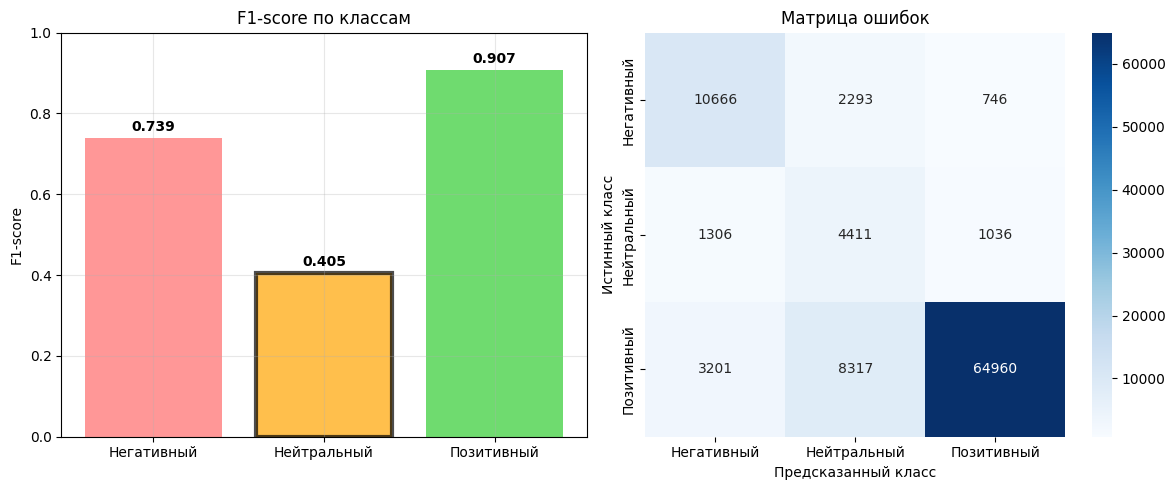

In [70]:
# Оценка модели
best_model_name = evaluate_single_model(results, y_test)

# Получаем обученную модель для дальнейшего использования
best_model = results[best_model_name]['model']

По матрице ошибок можно понять что нейтральный отзыв чаще всего относит модель к положительному классу. Также иногда модель принимает Позитивный класс за негативный.

### Задание 6
Интерпретация и визуализация:

a.	Визуализировать важные слова для каждого класса (coef_, SHAP, attention scores).

b.	Описать ключевые различия между отзывами разных тонов.


In [77]:
def visualize_feature_importance(model, tfidf_vectorizer, model_name="LogisticRegression"):
    print(f"\nАнализ важности признаков")
    print("=" * 60)

    # Получаем веса признаков
    if hasattr(model, 'coef_'):
        coefficients = model.coef_
    else:
        print("Модель не поддерживает анализ коэффициентов")
        return None, None

    # Проверяем структуру коэффициентов
    print(f"Структура коэффициентов: {coefficients.shape}")

    # Получаем названия признаков (только TF-IDF)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    print(f"Количество TF-IDF признаков: {len(feature_names)}")

    sentiment_labels = ['Негативный', 'Нейтральный', 'Позитивный']

    # Для каждого класса найдем топ-слова
    top_n = 15

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    for class_idx, (sentiment, ax) in enumerate(zip(sentiment_labels, axes)):
        # Берем коэффициенты для текущего класса
        class_coef = coefficients[class_idx, :len(feature_names)]

        # Получаем индексы топ-признаков
        top_indices = np.argsort(np.abs(class_coef))[-top_n:]
        top_features = [feature_names[i] for i in top_indices]
        top_coef = class_coef[top_indices]

        # Сортируем по значению коэффициента
        sorted_indices = np.argsort(top_coef)
        top_features_sorted = [top_features[i] for i in sorted_indices]
        top_coef_sorted = top_coef[sorted_indices]

        # Определяем цвета (положительные - зеленый, отрицательные - красный)
        colors = ['red' if coef < 0 else 'green' for coef in top_coef_sorted]

        # Строим горизонтальный барплот
        ax.barh(range(len(top_features_sorted)), top_coef_sorted, color=colors, alpha=0.7)
        ax.set_yticks(range(len(top_features_sorted)))
        ax.set_yticklabels(top_features_sorted)
        ax.set_xlabel('Коэффициент')
        ax.set_title(f'Топ-{top_n} слов для класса\n"{sentiment}"')
        ax.grid(True, alpha=0.3, axis='x')

        ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Выводим топ-слова в текстовом виде
    print("\nТоп важных слов по классам:")
    print("-" * 60)

    for class_idx, sentiment in enumerate(sentiment_labels):
        # Берем коэффициенты для текущего класса
        if coefficients.ndim == 2:
            class_coef = coefficients[class_idx, :len(feature_names)]
        else:
            class_coef = coefficients[:len(feature_names)]

        # Положительные коэффициенты (способствуют классу)
        pos_indices = np.argsort(class_coef)[-10:]
        pos_features = [(feature_names[i], class_coef[i]) for i in pos_indices[::-1]]

        # Отрицательные коэффициенты (препятствуют классу)
        neg_indices = np.argsort(class_coef)[:10]
        neg_features = [(feature_names[i], class_coef[i]) for i in neg_indices]

        print(f"\n{sentiment}:")
        print(f"  Положительно влияющие слова:")
        for word, coef in pos_features:
            print(f"    {word}: {coef:.4f}")

        print(f"  Отрицательно влияющие слова:")
        for word, coef in neg_features:
            print(f"    {word}: {coef:.4f}")

    return coefficients, feature_names

In [79]:
def create_sentiment_wordclouds(df):
    print("\nСоздание облаков слов по классам тональности")
    print("=" * 60)

    sentiment_labels = {0: 'Негативный', 1: 'Нейтральный', 2: 'Позитивный'}
    colors = {0: 'Reds', 1: 'Oranges', 2: 'Greens'}

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for sentiment_id, sentiment_name in sentiment_labels.items():
        # Фильтруем отзывы по тональности
        sentiment_reviews = df[df['sentiment'] == sentiment_id]

        # Объединяем все токены для данного класса
        all_tokens = []
        for tokens in sentiment_reviews['Tokens']:
            all_tokens.extend(tokens)

        # Создаем частотный словарь
        word_freq = Counter(all_tokens)

        # Создаем облако слов
        wordcloud = WordCloud(
            width=600,
            height=400,
            background_color='white',
            max_words=100,
            colormap=colors[sentiment_id],
            contour_width=1,
            contour_color='steelblue',
            collocations=False
        ).generate_from_frequencies(word_freq)

        # Отображаем облако слов
        axes[sentiment_id].imshow(wordcloud, interpolation='bilinear')
        axes[sentiment_id].axis('off')
        axes[sentiment_id].set_title(f'Облако слов - {sentiment_name}\n({len(sentiment_reviews):,} отзывов)')

        # Выводим статистику
        print(f"\n{sentiment_name}:")
        print(f"  Количество отзывов: {len(sentiment_reviews):,}")
        print(f"  Общее количество слов: {len(all_tokens):,}")
        print(f"  Уникальных слов: {len(word_freq):,}")
        print(f"  Топ-10 слов: {', '.join([word for word, _ in word_freq.most_common(10)])}")

    plt.tight_layout()
    plt.show()

    return sentiment_labels


По анализу мы видим, что действительно, в негативных отзывах чаще попадаются слова негативного оттенка, в нейтральном классе слова часто не связанные с ощущением отпродукта, а имеющие отношение к сторонним условиям. Положительный класс якро выражен словами позитивной окраски.


Анализ важности признаков
Структура коэффициентов: (3, 15022)
Количество TF-IDF признаков: 15000


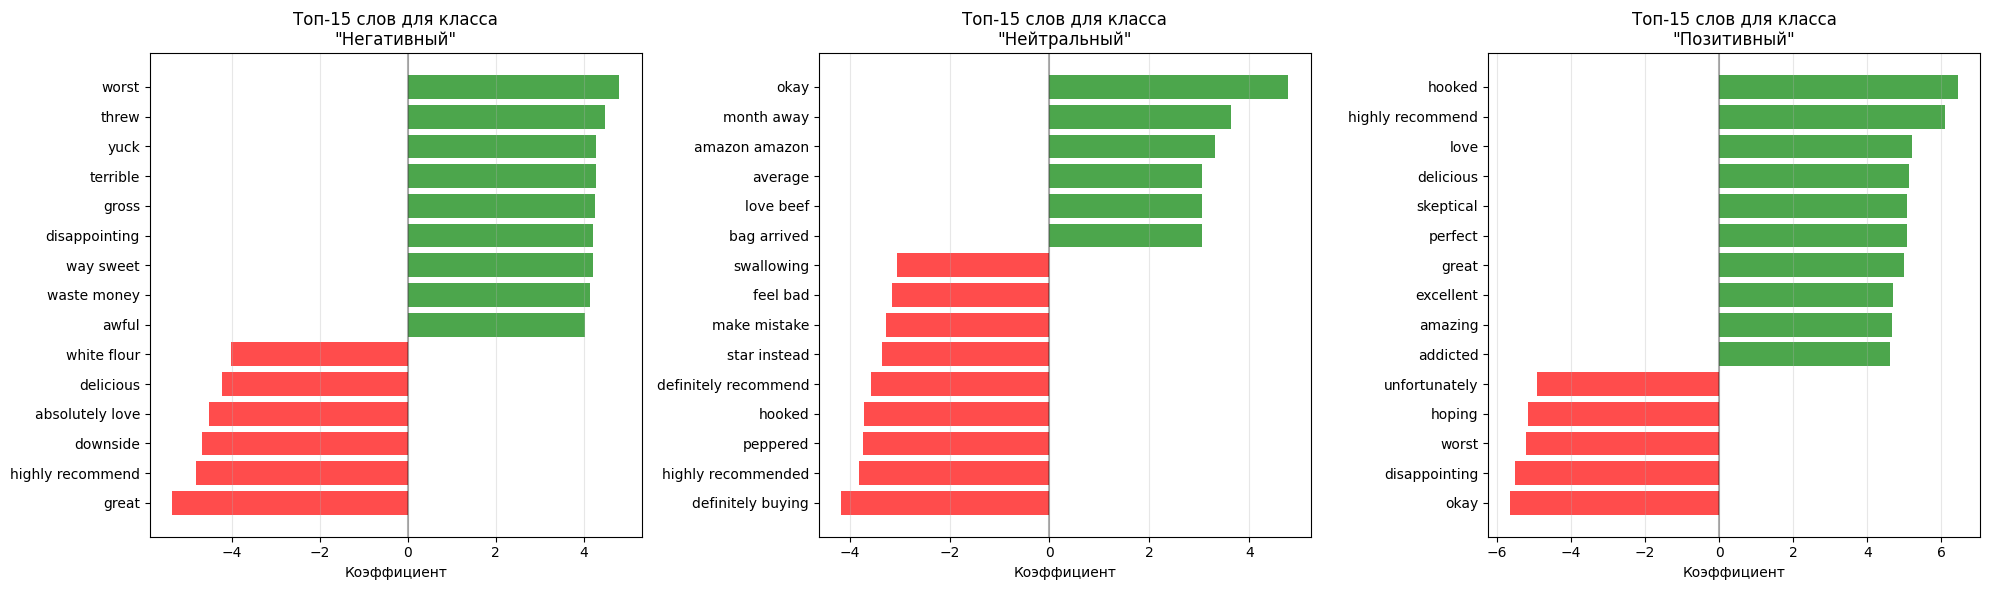


Топ важных слов по классам:
------------------------------------------------------------

Негативный:
  Положительно влияющие слова:
    worst: 4.8078
    threw: 4.4759
    yuck: 4.2881
    terrible: 4.2745
    gross: 4.2620
    disappointing: 4.2172
    way sweet: 4.2045
    waste money: 4.1532
    awful: 4.0235
    rip: 3.9276
  Отрицательно влияющие слова:
    great: -5.3632
    highly recommend: -4.8164
    downside: -4.6780
    absolutely love: -4.5138
    delicious: -4.2188
    white flour: -4.0328
    getting used: -3.9863
    bad thing: -3.8068
    french fry: -3.7735
    love: -3.7676

Нейтральный:
  Положительно влияющие слова:
    okay: 4.7833
    month away: 3.6427
    amazon amazon: 3.3212
    average: 3.0465
    love beef: 3.0463
    bag arrived: 3.0457
    vinegar chip: 2.9988
    neutral: 2.9977
    sent email: 2.9969
    mashed: 2.9675
  Отрицательно влияющие слова:
    definitely buying: -4.1670
    highly recommended: -3.8071
    peppered: -3.7244
    hooked: -3.713

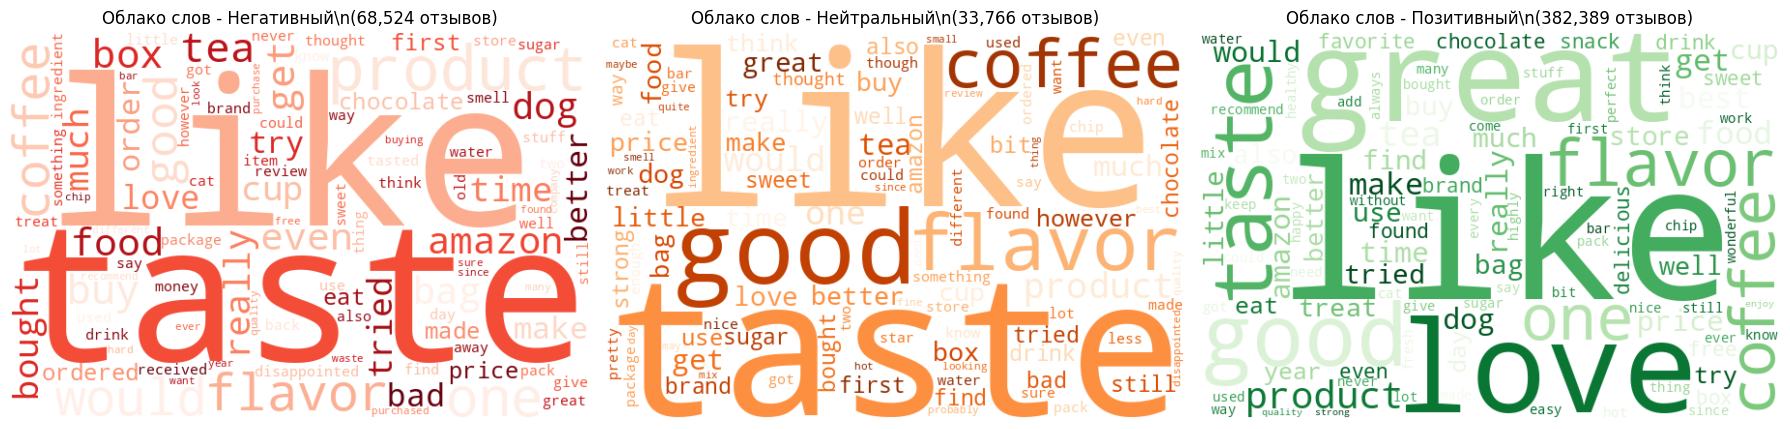

{0: 'Негативный', 1: 'Нейтральный', 2: 'Позитивный'}

In [73]:
# Анализ важности признаков для обученной модели
coefficients, feature_names = visualize_feature_importance(best_model, tfidf_vectorizer, best_model_name)
# Создание облаков слов по классам
create_sentiment_wordclouds(df)

По облакам слов мы видим что во всех отзывах используется слово like, но просто в разных контекстах. Также в нейтральных и отрицательных отхывах чаще упоминается вкус и сам продукт. В позитивном классе чаще указываются ощущения.

In [80]:
def analyze_sentiment_differences(df):

    print("\nАнализ различий между классами тональности")
    print("=" * 60)

    # Создаем сравнительную таблицу характеристик
    characteristics = []

    for sentiment_id in [0, 1, 2]:
        sentiment_data = df[df['sentiment'] == sentiment_id]
        sentiment_name = ['Негативный', 'Нейтральный', 'Позитивный'][sentiment_id]

        # Вычисляем характеристики
        avg_length = sentiment_data['word_count'].mean()
        avg_chars = sentiment_data['char_count'].mean()
        avg_exclamation = sentiment_data['Text'].str.count('!').mean()
        avg_question = sentiment_data['Text'].str.count(r'\\?').mean()

        # Полярность TextBlob
        sentiments = sentiment_data['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
        avg_polarity = sentiments.mean()

        characteristics.append({
            'Тональность': sentiment_name,
            'Средняя длина (слова)': avg_length,
            'Средняя длина (символы)': avg_chars,
            'Восклицательные знаки': avg_exclamation,
            'Вопросительные знаки': avg_question,
            'Полярность TextBlob': avg_polarity
        })

    comparison_df = pd.DataFrame(characteristics)

    print("\nСравнительная таблица характеристик:")
    print("-" * 80)
    for col in comparison_df.columns[1:]:
        print(f"\n{col}:")
        for _, row in comparison_df.iterrows():
            print(f"  {row['Тональность']:<12}: {row[col]:.3f}")

    # Визуализация различий
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    metrics = ['word_count', 'char_count', 'Text', 'Text',]
    operations = [lambda x: x, lambda x: x,
                 lambda x: x.str.count('!'),
                 lambda x: x.str.count(r'\\?'),
                 lambda x: x.str.count(r'\\b[A-Z]{2,}\\b')]
    titles = ['Длина в словах', 'Длина в символах', 'Восклицательные знаки',
              'Вопросительные знаки']

    sentiment_labels = ['Негативный', 'Нейтральный', 'Позитивный']
    colors = ['red', 'orange', 'green']

    for i, (metric, operation, title) in enumerate(zip(metrics, operations, titles)):
        if i >= 5:  # У нас только 5 метрик
            break

        data_to_plot = []
        labels_to_plot = []

        for sentiment_id, (sentiment_label, color) in enumerate(zip(sentiment_labels, colors)):
            sentiment_data = df[df['sentiment'] == sentiment_id]
            if metric == 'Text':
                values = operation(sentiment_data[metric])
            else:
                values = operation(sentiment_data[metric])
            data_to_plot.append(values)
            labels_to_plot.append(sentiment_label)

        # Boxplot для сравнения
        bp = axes[i].boxplot(data_to_plot, labels=labels_to_plot, patch_artist=True)
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        axes[i].set_title(title)
        axes[i].grid(True, alpha=0.3)

    # Полярность TextBlob
    polarity_data = []
    for sentiment_id in [0, 1, 2]:
        sentiment_data = df[df['sentiment'] == sentiment_id]
        polarities = sentiment_data['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
        polarity_data.append(polarities)

    bp = axes[5].boxplot(polarity_data, labels=sentiment_labels, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    axes[5].set_title('Полярность TextBlob')
    axes[5].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Выводы
    print("\n Ключевые выводы:")
    print("-" * 40)

    # Анализ длины
    neg_length = comparison_df.iloc[0]['Средняя длина (слова)']
    neu_length = comparison_df.iloc[1]['Средняя длина (слова)']
    pos_length = comparison_df.iloc[2]['Средняя длина (слова)']

    # Анализ полярности
    neg_pol = comparison_df.iloc[0]['Полярность TextBlob']
    neu_pol = comparison_df.iloc[1]['Полярность TextBlob']
    pos_pol = comparison_df.iloc[2]['Полярность TextBlob']

    print(f"\nПолярность (TextBlob):")
    print(f"Негативные: {neg_pol:.3f}")
    print(f"Нейтральные: {neu_pol:.3f}")
    print(f"Позитивные: {pos_pol:.3f}")

    return comparison_df



Анализ различий между классами тональности
\nСравнительная таблица характеристик:
--------------------------------------------------------------------------------
\nСредняя длина (слова):
  Негативный  : 28.736
  Нейтральный : 29.289
  Позитивный  : 26.443
\nСредняя длина (символы):
  Негативный  : 159.862
  Нейтральный : 161.508
  Позитивный  : 144.758
\nВосклицательные знаки:
  Негативный  : 0.523
  Нейтральный : 0.255
  Позитивный  : 0.751
\nВопросительные знаки:
  Негативный  : 327.574
  Нейтральный : 334.601
  Позитивный  : 293.488
\nПолярность TextBlob:
  Негативный  : 0.026
  Нейтральный : 0.163
  Позитивный  : 0.306


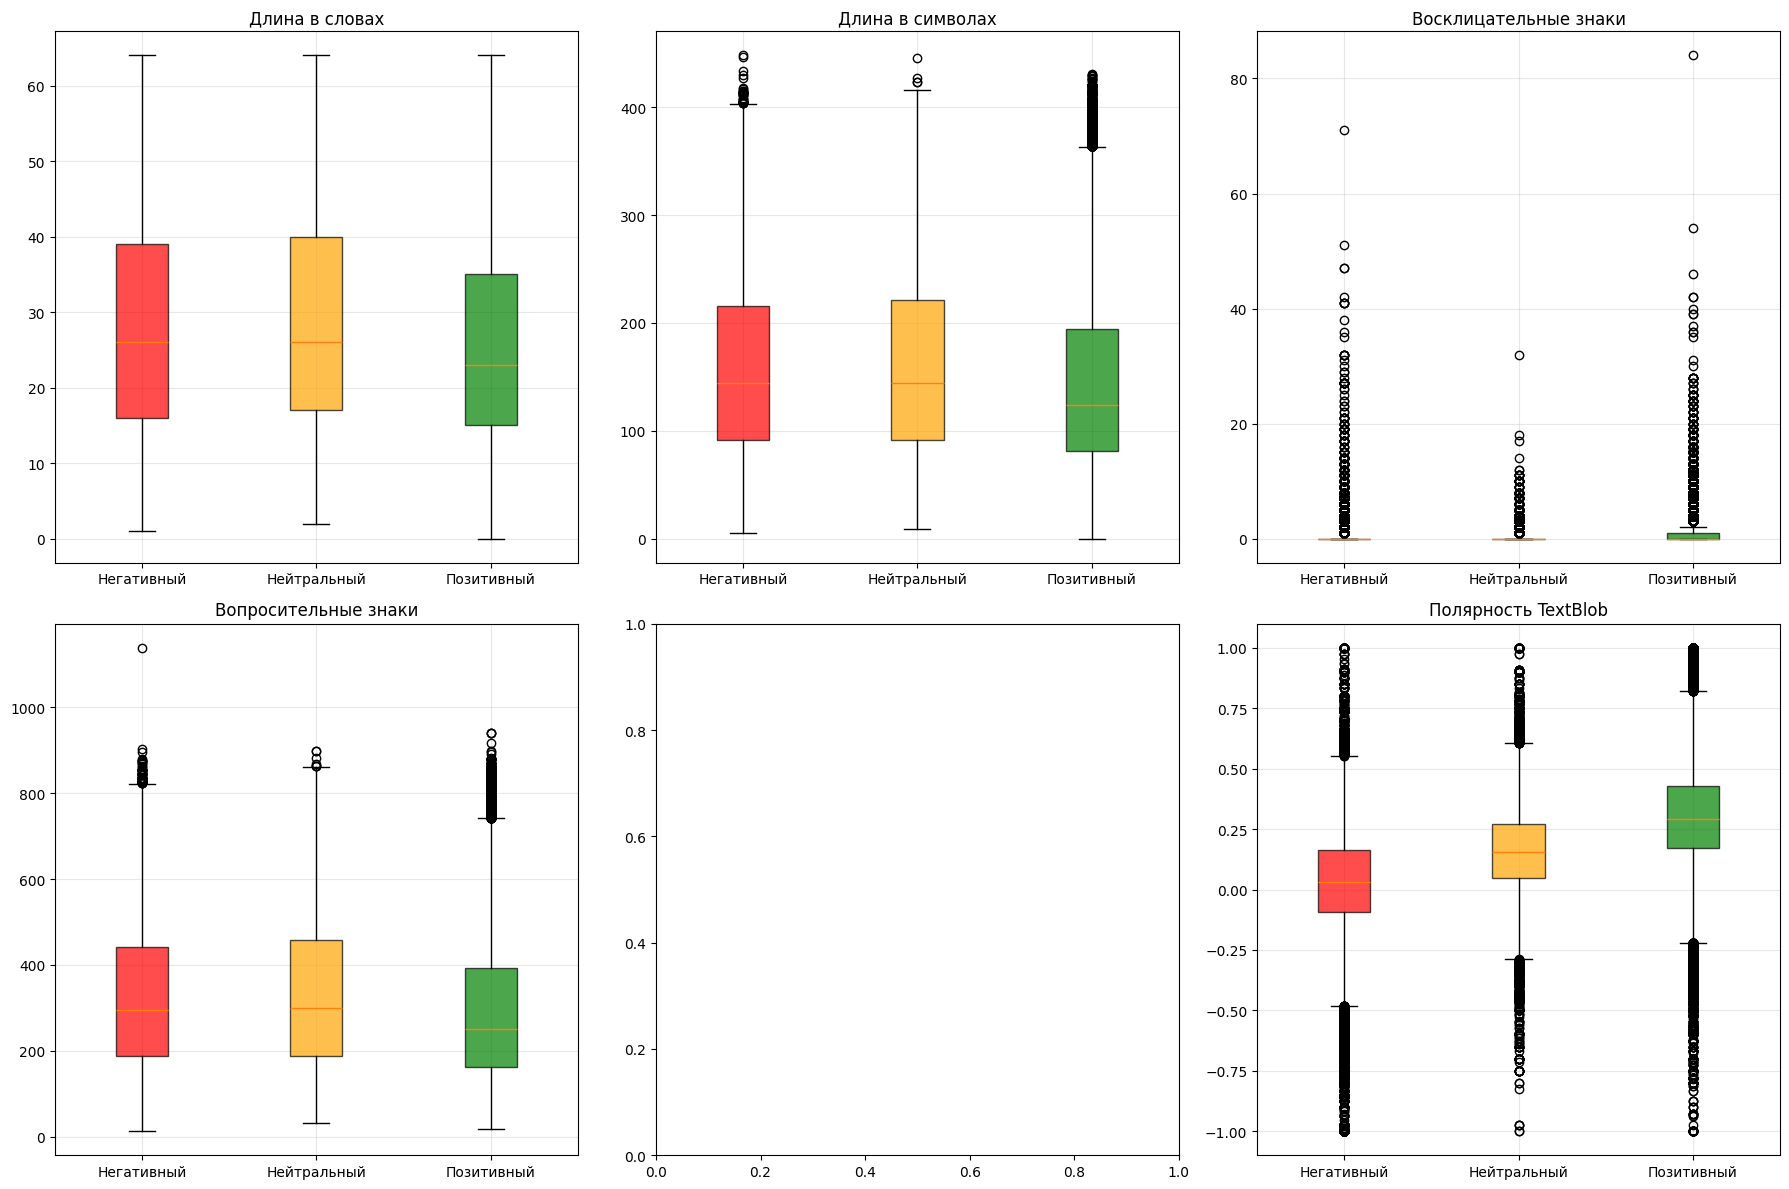

\n Ключевые выводы:
----------------------------------------
\nПолярность (TextBlob):
Негативные: 0.026
Нейтральные: 0.163
Позитивные: 0.306


In [81]:
# Шаг 7: Анализ различий между классами тональности
comparison_df = analyze_sentiment_differences(df)